In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from chainerrl import wrappers
from pathlib import Path
import pandas as pd

import seaborn
seaborn.set_context("talk")

In [10]:
from dacbench.benchmarks import FastDownwardBenchmark, SigmoidBenchmark
from dacbench.wrappers import PerformanceTrackingWrapper, RewardNoiseWrapper
from dacbench.logger import Logger, load_logs, log2dataframe
from dacbench.plotting import plot_performance, plot_performance_per_instance
from examples.example_utils import make_chainer_dqn, train_chainer

In [11]:
# Benchmarks are environments created by benchmark classes
# Initiliaze benchmark class
bench = SigmoidBenchmark()
# The config attribute shows the current benchmark configuration 
print(bench.config)

{'action_space_class': 'Discrete', 'action_space_args': [50], 'observation_space_class': 'Box', 'observation_space_type': <class 'numpy.float32'>, 'observation_space_args': [array([-inf, -inf, -inf, -inf, -inf, -inf, -inf]), array([inf, inf, inf, inf, inf, inf, inf])], 'reward_range': (0, 1), 'cutoff': 10, 'action_values': (5, 10), 'slope_multiplier': 2.0, 'seed': 0, 'instance_set_path': '../instance_sets/sigmoid/sigmoid_2D3M_train.csv', 'benchmark_info': {'identifier': 'Sigmoid', 'name': 'Sigmoid Function Approximation', 'reward': 'Multiplied Differences between Function and Action in each Dimension', 'state_description': ['Remaining Budget', 'Shift (dimension 1)', 'Slope (dimension 1)', 'Shift (dimension 2)', 'Slope (dimension 2)', 'Action 1', 'Action 2']}}


In [12]:
# Important human readable information is in benchmark_info
print(bench.config.benchmark_info)

{'identifier': 'Sigmoid', 'name': 'Sigmoid Function Approximation', 'reward': 'Multiplied Differences between Function and Action in each Dimension', 'state_description': ['Remaining Budget', 'Shift (dimension 1)', 'Slope (dimension 1)', 'Shift (dimension 2)', 'Slope (dimension 2)', 'Action 1', 'Action 2']}


In [13]:
# Now get interactive environment:
env = bench.get_benchmark()

In [16]:
# Before each run, reset the environment
state = env.reset()
print(state)

[10.          1.57994649  1.03789863  6.3748852   4.2193307  -1.
 -1.        ]


In [15]:
# Execute one algorithm run with a static action setting of 1
done = False
cum_reward = 0
while not done:
    state, reward, done, info = env.step(1)
    cum_reward += reward
print(f"Episode 1/1...........................................Reward: {cum_reward}")

Episode 1/1...........................................Reward: 0.9696103736404875


In [3]:
# A more complex example: run FastDownward with the integrated Logger and multiple seeds

# Automatically setting up env and logger
def setup_env(seed):
    # Get benchmark env
    bench = FastDownwardBenchmark()
    env = bench.get_benchmark(seed=seed)
    
    # Make logger to write results to file
    logger = Logger(experiment_name=f"FD_s{seed}", output_path=Path("example"))
    perf_logger = logger.add_module(PerformanceTrackingWrapper)
    
    # Wrap the environment to add noise and track the reward
    env = RewardNoiseWrapper(env, noise_dist="normal", dist_args=[0, 0.3])
    env = PerformanceTrackingWrapper(env, logger=perf_logger)
    logger.set_env(env)
    logger.set_additional_info(seed=seed)
    
    return env, logger

In [4]:
# Run a few episodes for 5 seeds each
for seed in [0, 1, 2, 3, 4, 5]:
    env, logger = setup_env(seed)
    
    # This could be any optimization or learning method
    rl_agent = make_chainer_dqn(env.observation_space.low.size, env.action_space)
    env = wrappers.CastObservationToFloat32(env)
    
    train_chainer(rl_agent, env, num_episodes=10, logger=logger)

Episode 0/10...........................................Reward: -264.6945266185836
Episode 1/10...........................................Reward: -273.7125327253623
Episode 2/10...........................................Reward: -216.0078640184256
Episode 3/10...........................................Reward: -211.84717898466877
Episode 4/10...........................................Reward: -138.03956994053175
Episode 5/10...........................................Reward: -60.79020142541636
Episode 6/10...........................................Reward: -21.2873259190673
Episode 7/10...........................................Reward: -53.80055533501202
Episode 8/10...........................................Reward: -1006.9139661427524
Episode 9/10...........................................Reward: -217.04809331130585
Episode 0/10...........................................Reward: -254.66253111793566
Episode 1/10...........................................Reward: -218.70659033039453
Episode 2/1

In [5]:
# Load results for all seeds
results = []
for seed in [0, 1, 2, 3, 4, 5]:
    logs = load_logs(f"example/FD_s{seed}/PerformanceTrackingWrapper.jsonl")
    results.append(log2dataframe(logs, wide=True))
results = pd.concat(results)

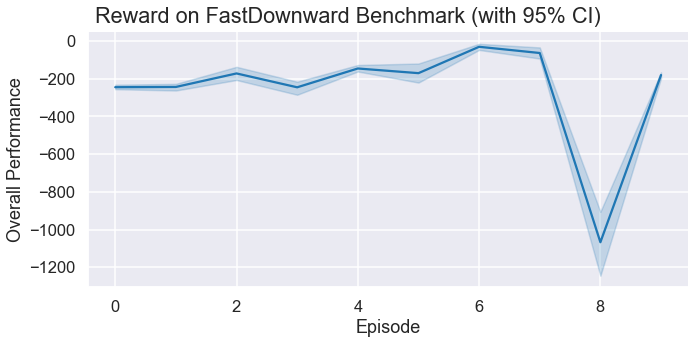

In [6]:
# Plot performance over time
plot = plot_performance(results, title="Reward on FastDownward Benchmark (with 95% CI)", aspect=2)

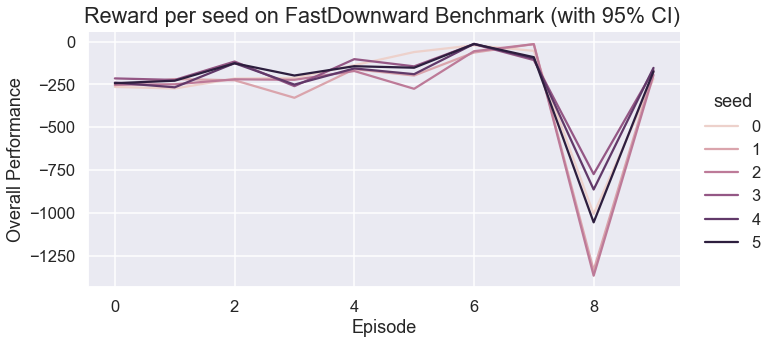

In [7]:
# Compare performance on seeds
plot = plot_performance(results, title="Reward per seed on FastDownward Benchmark (with 95% CI)", hue="seed", aspect=2)

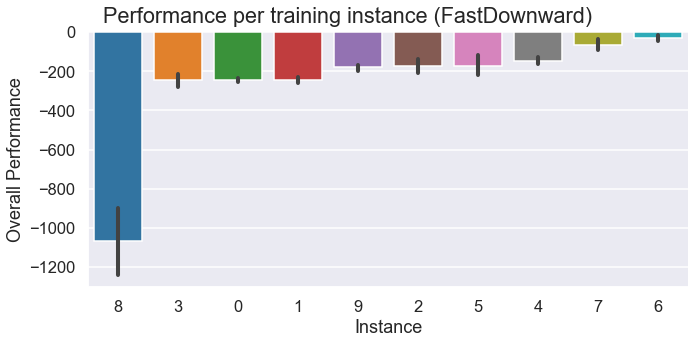

In [8]:
# Plot mean performance per instance
plot_performance_per_instance(results, title="Performance per training instance (FastDownward)", aspect=2)